In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install deepface
!pip install -U retinaface_pytorch > /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 7.3 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=8db3cfb29fff3e534d08077440d6784f78b2cd76f5c2bf8960c88130260913ca
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [3]:
import cv2
import torch
import numpy as np
import gc
from deepface import DeepFace
from retinaface.pre_trained_models import get_model
import math
from builtins import input

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [ ]:
# Load RetinaFace detection model
detection_model = get_model("resnet50_2020-07-20", max_size=2048)
detection_model.eval()

Downloading: "https://github.com/ternaus/retinaface/releases/download/0.01/retinaface_resnet50_2020-07-20-f168fae3c.zip" to /root/.cache/torch/hub/checkpoints/retinaface_resnet50_2020-07-20-f168fae3c.zip
100%|██████████| 96.9M/96.9M [00:01<00:00, 51.9MB/s]


In [ ]:
!cp -r "/content/drive/MyDrive/FaceDataBase_Extracted" "/content"
!rm -r "/content/FaceDataBase_Extracted/representations_arcface.pkl"
!rm -r "/content/FaceDataBase_Extracted/representations_facenet.pkl"
!rm -r "/content/FaceDataBase_Extracted/dataset.json"
!rm -r "/content/FaceDataBase_Extracted/data.json"

rm: cannot remove '/content/FaceDataBase_Extracted/representations_arcface.pkl': No such file or directory


In [ ]:
import json
import os
dict_person={}
dict_person['labels'] = []
file_path = '/content/FaceDataBase_Extracted'
persons_name = os.listdir(file_path)
persons_name.sort()
for idx,person_name in enumerate(persons_name):
  person_path = os.path.join(file_path,person_name)
  imgs_name = os.listdir(person_path)
  for img_name in imgs_name:
    img_path = os.path.join(person_name,img_name)
    dict_person['labels'].append([img_path,person_name])
print(dict_person)
with open(os.path.join(file_path,'dataset.json'), "w") as outfile:
    json.dump(dict_person, outfile)

{'labels': [['Abby_Phillip/Abby_Phillip2.jpg', 'Abby_Phillip'], ['Abby_Phillip/Abby_Phillip1.jpg', 'Abby_Phillip'], ['Abby_Phillip/Abby_Phillip3.jpg', 'Abby_Phillip'], ['Alexandria_Ocasio-Cortez/Alexandria_Ocasio-Cortez1.jpg', 'Alexandria_Ocasio-Cortez'], ['Alexandria_Ocasio-Cortez/Alexandria_Ocasio-Cortez3.jpg', 'Alexandria_Ocasio-Cortez'], ['Alexandria_Ocasio-Cortez/Alexandria_Ocasio-Cortez2.jpg', 'Alexandria_Ocasio-Cortez'], ['Anderson_Cooper/Anderson_Cooper3.jpg', 'Anderson_Cooper'], ['Anderson_Cooper/Anderson_Cooper2.jpg', 'Anderson_Cooper'], ['Anderson_Cooper/Anderson_Cooper1.jpg', 'Anderson_Cooper'], ['Andy_Cohen/Andy_Cohen2.jpg', 'Andy_Cohen'], ['Andy_Cohen/Andy_Cohen1.jpg', 'Andy_Cohen'], ['Anthony_Fauci/Anthony_Fauci2.jpg', 'Anthony_Fauci'], ['Anthony_Fauci/Anthony_Fauci1.jpg', 'Anthony_Fauci'], ['Barack_Obama/Barack_Obama2.jpg', 'Barack_Obama'], ['Barack_Obama/Barack_Obama1.jpg', 'Barack_Obama'], ['Candace_Owens/Candace_Owens3.jpg', 'Candace_Owens'], ['Candace_Owens/Candace_

In [ ]:
with open(os.path.join(file_path,'dataset.json')) as outfile:
    dict_img = json.load(outfile)
x = np.array([x[0] for x in dict_img['labels']])
y = np.array([x[1] for x in dict_img['labels']])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)
X_train.shape, y_train.shape

((77,), (77,))

In [ ]:
X_test.shape, y_test.shape


((52,), (52,))

In [ ]:
# ASLI
# Load a sample image
# img = cv2.imread('/content/download.jfif')

# # Perform face detection
# all_faces = detection_model.predict_jsons(img)

# # Process each detected face
# for face in all_faces:
#     if len(face['bbox']) > 3:
#         x, y, x1, y1 = face['bbox']
#         w, h = abs(x1 - x), abs(y1 - y)
#         face_img = img[int(y):int(min(y + h, img.shape[0])),
#                        int(x):int(min(x + w, img.shape[1]))]
#         cv2.imwrite('faces1.jpg', face_img)

# # Build the DeepFace recognition model
model = DeepFace.build_model('Facenet')

def recognize_person(face_img):

        face_img_bgr = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        df_fr = DeepFace.find(face_img_bgr,
                              db_path="/content/FaceDataBase_Extracted",
                              enforce_detection=False,
                              detector_backend='retinaface',
                              model_name='Facenet',
                              distance_metric="euclidean_l2")

        closest_identity = min(df_fr, key=lambda x: x['Facenet_euclidean_l2'])
        try:
          verified_identity = closest_identity['identity'][0].split('/')[-2]

          return verified_identity
        except:
          return None



# # Process and recognize a face
# person_face = cv2.imread('faces1.jpg')
# verified_identity = recognize_person(person_face)

# if verified_identity is None:
#     print('No Face Detected')
# else:
#     print('Verified Identity:', verified_identity)


In [ ]:
test_images_path = '/content/FaceDataBase_Extracted'  # Path to test images

In [ ]:
#get 96 accuracy
import cv2
import os
from deepface import DeepFace

# Define the paths
test_images_path = '/content/FaceDataBase_Extracted'

# Load the recognition model
recognition_model = DeepFace.build_model('Facenet')

# Function to recognize a person
def recognize_person(face_img):
    face_img_bgr = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    df_fr = DeepFace.find(
        face_img_bgr,
        db_path=test_images_path,
        enforce_detection=False,
        detector_backend='retinaface',  # Use RetinaFace for face detection
        model_name='Facenet',
        distance_metric="euclidean_l2"
    )

    closest_identity = min(df_fr, key=lambda x: x['Facenet_euclidean_l2'])
    try:
        verified_identity = closest_identity['identity'][0].split('/')[-2]
        return verified_identity
    except:
        return None

# Process and recognize each test image
correct_predictions = 0

for i, test_image_filename in enumerate(X_test):
    test_image_path = os.path.join(test_images_path, test_image_filename)
    img = cv2.imread(test_image_path)

    # Perform face recognition
    verified_identity = recognize_person(img)
    print(verified_identity, y_test[i])

    if verified_identity is not None and verified_identity == y_test[i]:
        correct_predictions += 1

accuracy = correct_predictions / len(X_test) * 100
print('Accuracy:', accuracy)


Finding representations: 100%|██████████| 129/129 [17:55<00:00,  8.34s/it]


Representations stored in /content/FaceDataBase_Extracted/representations_facenet.pkl file.Please delete this file when you add new identities in your database.
find function lasts  1083.6242773532867  seconds
Donald_Trump Donald_Trump
There are  129  representations found in  representations_facenet.pkl
find function lasts  11.008673429489136  seconds
Cristiano_Ronaldo Cristiano_Ronaldo
There are  129  representations found in  representations_facenet.pkl
find function lasts  9.173325538635254  seconds
Prince_Harry Prince_Harry
There are  129  representations found in  representations_facenet.pkl
find function lasts  5.69388747215271  seconds
Gloria_Borger Gloria_Borger
There are  129  representations found in  representations_facenet.pkl
find function lasts  10.468950986862183  seconds
None Anderson_Cooper
There are  129  representations found in  representations_facenet.pkl
find function lasts  5.878223180770874  seconds
Steve_Harvey Steve_Harvey
There are  129  representations foun

# Test on lfw

In [ ]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/LFW/subset" "/content"

In [ ]:
!rm -r "/content/subset/representations_arcface.pkl"
!rm -r "/content/subset/representations_facenet.pkl"
!rm -r "/content/subset/dataset.json"
!rm -r "/content/subset/data.json"

rm: cannot remove '/content/subset/representations_arcface.pkl': No such file or directory
rm: cannot remove '/content/subset/representations_facenet.pkl': No such file or directory
rm: cannot remove '/content/subset/dataset.json': No such file or directory
rm: cannot remove "'/content/drive/MyDrive/Colab Notebooks/LFW/subset/dataset.json": No such file or directory


In [4]:
import json
import os
dict_person={}
dict_person['labels'] = []
file_path = '/content/drive/MyDrive/Colab Notebooks/LFW/subset'
persons_name = os.listdir(file_path)
persons_name.sort()
for idx,person_name in enumerate(persons_name):
  person_path = os.path.join(file_path,person_name)
  imgs_name = os.listdir(person_path)
  for img_name in imgs_name:
    img_path = os.path.join(person_name,img_name)
    dict_person['labels'].append([img_path,person_name])
print(dict_person)
with open(os.path.join(file_path,'dataset.json'), "w") as outfile:
    json.dump(dict_person, outfile)

{'labels': [['Aaron_Sorkin/Aaron_Sorkin_0001.jpg', 'Aaron_Sorkin'], ['Aaron_Sorkin/Aaron_Sorkin_0002.jpg', 'Aaron_Sorkin'], ['Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg', 'Abdel_Aziz_Al-Hakim'], ['Adolfo_Aguilar_Zinser/Adolfo_Aguilar_Zinser_0001.jpg', 'Adolfo_Aguilar_Zinser'], ['Adolfo_Aguilar_Zinser/Adolfo_Aguilar_Zinser_0002.jpg', 'Adolfo_Aguilar_Zinser'], ['Adolfo_Aguilar_Zinser/Adolfo_Aguilar_Zinser_0003.jpg', 'Adolfo_Aguilar_Zinser'], ['Agnelo_Queiroz/Agnelo_Queiroz_0001.jpg', 'Agnelo_Queiroz'], ['Agnes_Bruckner/Agnes_Bruckner_0001.jpg', 'Agnes_Bruckner'], ['Albert_Brooks/Albert_Brooks_0001.jpg', 'Albert_Brooks'], ['Albrecht_Mentz/Albrecht_Mentz_0001.jpg', 'Albrecht_Mentz'], ['Albrecht_Mentz/Albrecht_Mentz_0002.jpg', 'Albrecht_Mentz'], ['Alfonso_Portillo/Alfonso_Portillo_0001.jpg', 'Alfonso_Portillo'], ['Amy_Yasbeck/Amy_Yasbeck_0001.jpg', 'Amy_Yasbeck'], ['AnFernce_Negron/AnFernce_Negron_0001.jpg', 'AnFernce_Negron'], ['Ana_Palacio/Ana_Palacio_0001.jpg', 'Ana_Palacio'], ['An

In [5]:
with open(os.path.join(file_path,'dataset.json')) as outfile:
    dict_img = json.load(outfile)
x = np.array([x[0] for x in dict_img['labels']])
y = np.array([x[1] for x in dict_img['labels']])


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)
X_train.shape, y_train.shape

((865,), (865,))

In [ ]:
import pickle

# Load X_test
with open('X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)

# Load y_test
with open('y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)


FileNotFoundError: ignored

In [7]:
import pickle

# Save X_test
with open('X_test.pkl', 'wb') as file:
    pickle.dump(X_test, file)

# Save y_test
with open('y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)


In [8]:
X_test.shape, y_test.shape

((578,), (578,))

In [ ]:
X_test

array(['Serena_Williams/Serena_Williams_0018.jpg',
       'Jeremy_Greenstock/Jeremy_Greenstock_0016.jpg',
       'Diana_Krall/Diana_Krall_0005.jpg',
       'Halle_Berry/Halle_Berry_0001.jpg',
       'Ronald_Ito/Ronald_Ito_0001.jpg', 'Tony_Blair/Tony_Blair_0138.jpg',
       'Sergey_Lavrov/Sergey_Lavrov_0008.jpg',
       'Kathryn_Tucker/Kathryn_Tucker_0001.jpg',
       'John_Negroponte/John_Negroponte_0003.jpg',
       'Hans_Blix/Hans_Blix_0037.jpg',
       'Jayson_Williams/Jayson_Williams_0001.jpg',
       'Angela_Merkel/Angela_Merkel_0001.jpg',
       'Roger_Clemens/Roger_Clemens_0001.jpg',
       'Aron_Ralston/Aron_Ralston_0001.jpg',
       'Jim_Edmonds/Jim_Edmonds_0001.jpg',
       'Jason_Petty/Jason_Petty_0001.jpg',
       'Mohamed_Seineldin/Mohamed_Seineldin_0001.jpg',
       'Hamad_Bin_Isa_al-Khalifa/Hamad_Bin_Isa_al-Khalifa_0001.jpg',
       'Atiabet_Ijan_Amabel/Atiabet_Ijan_Amabel_0001.jpg',
       'Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0001.jpg',
       'Claire_Danes/Claire

In [ ]:
import cv2
import os
from deepface import DeepFace

# Define the paths
test_images_path = '/content/drive/MyDrive/Colab Notebooks/LFW/subset'

# Load the recognition model
recognition_model = DeepFace.build_model('Facenet')

def recognize_person(face_img):
  """Recognizes a person in an image.

  Args:
    face_img: A numpy array representing the face image.

  Returns:
    The identity of the person in the image, or `None` if no match is found.
  """

  face_img_bgr = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
  df_fr = DeepFace.find(
      face_img_bgr,
      db_path=test_images_path,
      enforce_detection=False,
      detector_backend='retinaface',
      model_name='Facenet',
      distance_metric="euclidean_l2")

  for result in df_fr:
    if (result['Facenet_euclidean_l2'] < 0.6).any():
      verified_identity = result['identity'].iloc[0].split('/')[-2]
      return verified_identity

  # If no match is found, return `None`
  return None

def calculate_accuracy(X_test, y_test):
  """Calculates the accuracy of a face recognition model on a test set.

  Args:
    X_test: A list of image paths.
    y_test: A list of labels for the images in X_test.

  Returns:
    The accuracy of the model on the test set.
  """

  correct_predictions = 0

  for i, test_image_filename in enumerate(X_test):
    test_image_path = os.path.join(test_images_path, test_image_filename)
    print(test_image_path)
    img = cv2.imread(test_image_path)

    # Perform face recognition
    verified_identity = recognize_person(img)
    print(verified_identity, y_test[i])

    if verified_identity is not None and verified_identity == y_test[i]:
      correct_predictions += 1

  accuracy = correct_predictions / len(X_test) * 100
  print('Accuracy:', accuracy)

  return accuracy

# Calculate the accuracy of the model
accuracy = calculate_accuracy(X_test, y_test)

# If the accuracy is not satisfactory, try to improve it by following the tips above


/content/drive/MyDrive/Colab Notebooks/LFW/subset/Serena_Williams/Serena_Williams_0018.jpg
There are  1869  representations found in  representations_facenet.pkl
find function lasts  7.913900852203369  seconds
Serena_Williams Serena_Williams
/content/drive/MyDrive/Colab Notebooks/LFW/subset/Jeremy_Greenstock/Jeremy_Greenstock_0016.jpg
There are  1869  representations found in  representations_facenet.pkl
find function lasts  7.173017978668213  seconds
Jeremy_Greenstock Jeremy_Greenstock
/content/drive/MyDrive/Colab Notebooks/LFW/subset/Diana_Krall/Diana_Krall_0005.jpg
There are  1869  representations found in  representations_facenet.pkl
find function lasts  5.596047639846802  seconds
Diana_Krall Diana_Krall
/content/drive/MyDrive/Colab Notebooks/LFW/subset/Halle_Berry/Halle_Berry_0001.jpg
There are  1869  representations found in  representations_facenet.pkl
find function lasts  8.982495546340942  seconds
Halle_Berry Halle_Berry
/content/drive/MyDrive/Colab Notebooks/LFW/subset/Ronald

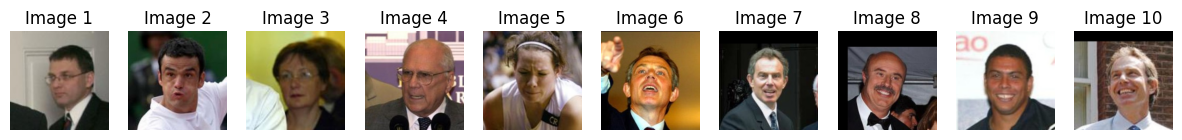

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# List of image file paths
image_paths = [
    "/content/drive/MyDrive/Colab Notebooks/LFW/subset/Lubomir_Zaoralek/Lubomir_Zaoralek_0001.jpg",
    "/content/drive/MyDrive/Colab Notebooks/LFW/subset/Hermes_Gamonal/Hermes_Gamonal_0001.jpg",
    "/content/drive/MyDrive/Colab Notebooks/LFW/subset/Barbara_De_Brun/Barbara_De_Brun_0001.jpg",
    '/content/drive/MyDrive/Colab Notebooks/LFW/subset/Enrique_Bolanos/Enrique_Bolanos_0002.jpg',
    '/content/drive/MyDrive/Colab Notebooks/LFW/subset/Beth_Jones/Beth_Jones_0002.jpg',
    '/content/drive/MyDrive/Colab Notebooks/LFW/subset/Tony_Blair/Tony_Blair_0090.jpg',
    '/content/drive/MyDrive/Colab Notebooks/LFW/subset/Tony_Blair/Tony_Blair_0007.jpg',
    '/content/drive/MyDrive/Colab Notebooks/LFW/subset/Phil_McGraw/Phil_McGraw_0001.jpg',
    '/content/drive/MyDrive/Colab Notebooks/LFW/subset/Ronaldo_Luis_Nazario_de_Lima/Ronaldo_Luis_Nazario_de_Lima_0003.jpg',
    '/content/drive/MyDrive/Colab Notebooks/LFW/subset/Tony_Blair/Tony_Blair_0069.jpg'

]

# Create a subplot for each image
num_images = len(image_paths)
fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

# Load and display each image
for i, image_path in enumerate(image_paths):
    img = Image.open(image_path)
    axs[i].imshow(img)
    axs[i].set_title(f"Image {i+1}")
    axs[i].axis('off')

plt.show()


In [9]:
#test augmentation
import cv2
import os
from deepface import DeepFace

# Define the paths
test_images_path = '/content/drive/MyDrive/Colab Notebooks/LFW/subset'

# Load the recognition model
recognition_model = DeepFace.build_model('Facenet')

def recognize_person(face_img):
  """Recognizes a person in an image.

  Args:
    face_img: A numpy array representing the face image.

  Returns:
    The identity of the person in the image, or `None` if no match is found.
  """

  face_img_bgr = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
  df_fr = DeepFace.find(
      face_img_bgr,
      db_path=test_images_path,
      enforce_detection=False,
      detector_backend='retinaface',
      model_name='Facenet',
      distance_metric="euclidean_l2")

  for result in df_fr:
    if (result['Facenet_euclidean_l2'] < 0.6).any():
      verified_identity = result['identity'].iloc[0].split('/')[-2]
      return verified_identity

  # If no match is found, return `None`
  return None

def calculate_accuracy(X_test, y_test):
  """Calculates the accuracy of a face recognition model on a test set.

  Args:
    X_test: A list of image paths.
    y_test: A list of labels for the images in X_test.

  Returns:
    The accuracy of the model on the test set.
  """

  correct_predictions = 0

  for i, test_image_filename in enumerate(X_test):
    test_image_path = os.path.join(test_images_path, test_image_filename)
    print(test_image_path)
    img = cv2.imread(test_image_path)

    # Perform face recognition
    verified_identity = recognize_person(img)
    print(verified_identity, y_test[i])

    if verified_identity is not None and verified_identity == y_test[i]:
      correct_predictions += 1

  accuracy = correct_predictions / len(X_test) * 100
  print('Accuracy:', accuracy)

  return accuracy

# Calculate the accuracy of the model
accuracy = calculate_accuracy(X_test, y_test)

# If the accuracy is not satisfactory, try to improve it by following the tips above


facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:00<00:00, 199MB/s]


/content/drive/MyDrive/Colab Notebooks/LFW/subset/Serena_Williams/Serena_Williams_0040.jpg


Finding representations:   0%|          | 0/1443 [00:00<?, ?it/s]

retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5

  0%|          | 0.00/119M [00:00<?, ?B/s]
  1%|▏         | 1.57M/119M [00:00<00:08, 13.6MB/s]
  5%|▌         | 6.29M/119M [00:00<00:03, 31.3MB/s]
 17%|█▋        | 19.9M/119M [00:00<00:01, 76.6MB/s]
 35%|███▌      | 41.9M/119M [00:00<00:00, 131MB/s] 
 48%|████▊     | 56.6M/119M [00:00<00:00, 134MB/s]
 72%|███████▏  | 84.9M/119M [00:00<00:00, 183MB/s]
100%|██████████| 119M/119M [00:00<00:00, 154MB/s]
Finding representations: 100%|██████████| 1443/1443 [18:14<00:00,  1.32it/s]


Representations stored in /content/drive/MyDrive/Colab Notebooks/LFW/subset/representations_facenet.pkl file.Please delete this file when you add new identities in your database.
find function lasts  1095.7042474746704  seconds
Serena_Williams Serena_Williams
/content/drive/MyDrive/Colab Notebooks/LFW/subset/Jeremy_Greenstock/Jeremy_Greenstock_0018.jpg
There are  1869  representations found in  representations_facenet.pkl
find function lasts  0.4801957607269287  seconds
Jeremy_Greenstock Jeremy_Greenstock
/content/drive/MyDrive/Colab Notebooks/LFW/subset/Diana_Krall/Diana_Krall_0001.jpg
There are  1869  representations found in  representations_facenet.pkl
find function lasts  0.4616682529449463  seconds
Diana_Krall Diana_Krall
/content/drive/MyDrive/Colab Notebooks/LFW/subset/Halle_Berry/Halle_Berry_0012.jpg
There are  1869  representations found in  representations_facenet.pkl
find function lasts  0.4941413402557373  seconds
Halle_Berry Halle_Berry
/content/drive/MyDrive/Colab Notebo

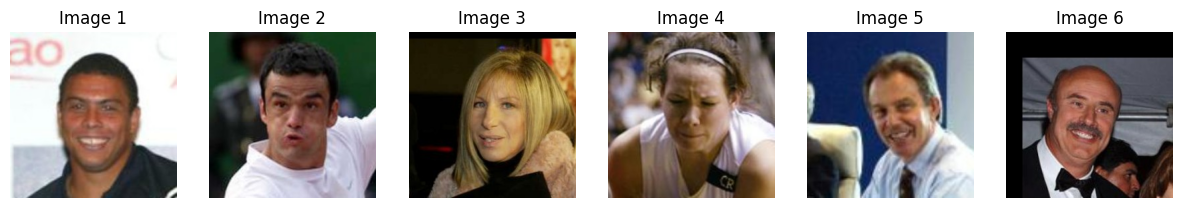

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

# List of image file paths
image_paths = [
    "/content/drive/MyDrive/Colab Notebooks/LFW/subset/Ronaldo_Luis_Nazario_de_Lima/Ronaldo_Luis_Nazario_de_Lima_0003.jpg",
    '/content/drive/MyDrive/Colab Notebooks/LFW/subset/Hermes_Gamonal/Hermes_Gamonal_0001.jpg',
    '/content/drive/MyDrive/Colab Notebooks/LFW/subset/Barbra_Streisand/Barbra_Streisand_0002.jpg',
    '/content/drive/MyDrive/Colab Notebooks/LFW/subset/Beth_Jones/Beth_Jones_0002.jpg',
    '/content/drive/MyDrive/Colab Notebooks/LFW/subset/Tony_Blair/Tony_Blair_0070.jpg',
    '/content/drive/MyDrive/Colab Notebooks/LFW/subset/Phil_McGraw/Phil_McGraw_0001.jpg']

# Create a subplot for each image
num_images = len(image_paths)
fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

# Load and display each image
for i, image_path in enumerate(image_paths):
    img = Image.open(image_path)
    axs[i].imshow(img)
    axs[i].set_title(f"Image {i+1}")
    axs[i].axis('off')

plt.show()

In [ ]:
import os
from collections import defaultdict

def count_pictures(directory):
    picture_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']  # Add more extensions if needed
    picture_counts = defaultdict(int)

    for root, _, files in os.walk(directory):
        for file in files:
            _, extension = os.path.splitext(file)
            if extension.lower() in picture_extensions:
                picture_counts[root] += 1

    if not picture_counts:
        return None, None, None, None

    min_count = min(picture_counts.values())
    max_count = max(picture_counts.values())

    min_dir = None
    max_dir = None

    for directory, count in picture_counts.items():
        if count == min_count and (min_dir is None or len(directory) < len(min_dir)):
            min_dir = directory
        if count == max_count and (max_dir is None or len(directory) < len(max_dir)):
            max_dir = directory

    return min_count, min_dir, max_count, max_dir

directory = '/content/drive/MyDrive/Colab Notebooks/LFW/subset'
min_count, min_dir, max_count, max_dir = count_pictures(directory)

if min_count is not None:
    print(f"Minimum picture count: {min_count} in directory: {min_dir}")
    print(f"Maximum picture count: {max_count} in directory: {max_dir}")
else:
    print("No pictures found in any subdirectory.")


Minimum picture count: 1 in directory: /content/drive/MyDrive/Colab Notebooks/LFW/subset/Pele
Maximum picture count: 39 in directory: /content/drive/MyDrive/Colab Notebooks/LFW/subset/Hans_Blix


In [12]:
import pandas as pd
df = pd.read_csv('/content/attribute_lfw.csv')
df

,person,No Eyewear,Eyeglasses,Sunglasses
0,Aaron Eckhart,1.565186,-1.296704,-1.542719
1,Aaron Guiel,0.954771,-0.990992,-1.167359
2,Aaron Patterson,1.298364,-1.498471,-1.285823
3,Aaron Peirsol,0.665695,-0.775940,-1.471629
4,Aaron Peirsol,1.666710,-0.910723,-1.993509
...,...,...,...,...
13138,Zorica Radovic,0.333529,-1.661762,-0.615137
13139,Zulfiqar Ahmed,0.803589,-1.555146,-0.860096
13140,Zumrati Juma,-1.405303,0.844077,-0.116514
13141,Zurab Tsereteli,1.934108,-1.218088,-1.707885
